## Import packages
Make sure you installed ***sklearn***, ***matplotlib*** and ***numpy*** if you use your local machine

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

## Prepare dataset (same as last time)
The 20 newsgroups text dataset: [Details](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)

In [2]:
dataset = sklearn.datasets.fetch_20newsgroups()
class Dataset:
  def __init__(self, dataset, start_idx, end_idx):
    self.data = dataset.data[start_idx:end_idx]
    self.labels = dataset.target[start_idx:end_idx]
    self.vecs = None

    
def split_dataset(dataset, train_rate=0.7):
  data_size = len(dataset.data)
  train_last_idx = int(train_rate * data_size)
  train = Dataset(dataset, 0, train_last_idx)
  test = Dataset(dataset, train_last_idx, data_size)
  return train, test

train, test = split_dataset(dataset)
print('train data size:', len(train.data))
print('test data size:', len(test.data))

train data size: 7919
test data size: 3395


In [3]:
print(train.labels)

[ 7  4  4 ...  5 16 18]


## NGrams
Convert a list of text documents to a matrix of token frequencies ([Details](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html))

In [4]:
unigram = CountVectorizer(ngram_range=(1,1))
bigram = CountVectorizer(ngram_range=(2,2))
trigram = CountVectorizer(ngram_range=(3,3))
#fourgram = CountVectorizer(ngram_range=(4,4))
combined = CountVectorizer(ngram_range=(1,3))
vectorizers = [unigram, bigram, trigram, combined]
print("Fitting vectorizers")
[vectorizer.fit(train.data) for vectorizer in vectorizers]

Fitting vectorizers


[CountVectorizer(),
 CountVectorizer(ngram_range=(2, 2)),
 CountVectorizer(ngram_range=(3, 3)),
 CountVectorizer(ngram_range=(1, 3))]

### See vocabulary size
Q: Which one has the largest vocabulary size, **unigram**, **bigram**, **trigram**, or **combined**?

In [5]:
for vectorizer in vectorizers:
  print('Vocabulary Size:', len(vectorizer.vocabulary_))

Vocabulary Size: 107212
Vocabulary Size: 825425
Vocabulary Size: 1514525
Vocabulary Size: 2447162


### See vocabulary distribution
Q: Do you remember the name of the law?

In [6]:
def show_distribution(vectorizer, train):
  vecs = vectorizer.transform(train.data)
  sum_mat = np.sum(vecs, axis=0)
  freqs = np.sort(sum_mat).T[::-1]
  plt.plot(list(range(1, sum_mat.shape[1] + 1)), freqs)
  plt.xlabel('Rank')
  plt.ylabel('Frequency')
  plt.show()
  
  plt.loglog(list(range(1, sum_mat.shape[1] + 1)), freqs)
  plt.xlabel('Rank')
  plt.ylabel('Frequency')
  plt.show()

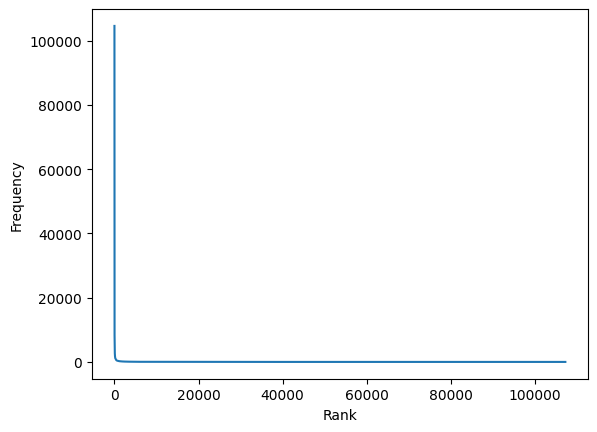

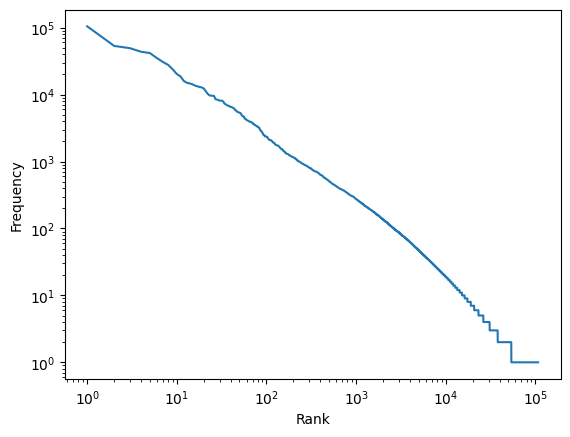

In [7]:
show_distribution(unigram, train) # try bigram, trigram and combined as well

### Convert word (ngram) to index and vice versa

In [8]:
def ngram2idx(ngram, vocab_dict):
  index = vocab_dict[ngram] if ngram in vocab_dict.keys() else 'Not Found'
  print(ngram, ' -> ', index)


def idx2ngram(index, vocabs):
  ngram = vocabs[index] if 0 <= index < len(vocabs) else 'Not Found'
  print(index, ' -> ', ngram)

In [9]:
vectorizer = unigram # change to bigram or trigram
vocab_dict = vectorizer.vocabulary_
vocabs = vectorizer.get_feature_names_out()

ngram2idx('we are', vocab_dict)
idx2ngram(783807, vocabs)

ngram2idx('to microsoft', vocab_dict)
idx2ngram(736413, vocabs)

we are  ->  Not Found
783807  ->  Not Found
to microsoft  ->  Not Found
736413  ->  Not Found


### Convert sentence to vector

In [10]:
def sentence2vec(sentence, vectorizer):
  vec = vectorizer.transform([sentence])
  vocabs = vectorizer.get_feature_names_out()
  print('\"', sentence, '\" -> ')
  print(vec)
  for idx in vec.indices:
    print(idx, vocabs[idx])
  print()

In [11]:
for vectorizer in vectorizers:
  sentence2vec('We are going to microsoft', vectorizer)

" We are going to microsoft " -> 
  (0, 23184)	1
  (0, 48917)	1
  (0, 67270)	1
  (0, 95302)	1
  (0, 101951)	1
23184 are
48917 going
67270 microsoft
95302 to
101951 we

" We are going to microsoft " -> 
  (0, 109903)	1
  (0, 328698)	1
  (0, 736413)	1
  (0, 783807)	1
109903 are going
328698 going to
736413 to microsoft
783807 we are

" We are going to microsoft " -> 
  (0, 171354)	1
  (0, 1424292)	1
171354 are going to
1424292 we are going

" We are going to microsoft " -> 
  (0, 300895)	1
  (0, 304432)	1
  (0, 304443)	1
  (0, 919583)	1
  (0, 919995)	1
  (0, 1336821)	1
  (0, 2147049)	1
  (0, 2166280)	1
  (0, 2309753)	1
  (0, 2309963)	1
  (0, 2310052)	1
300895 are
304432 are going
304443 are going to
919583 going
919995 going to
1336821 microsoft
2147049 to
2166280 to microsoft
2309753 we
2309963 we are
2310052 we are going



## TFIDF Weights

### Tutorial with unigram
Convert a collection of raw documents to a matrix of TF-IDF features. ([Details](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html))

In [12]:
example_docs=[
       "One Cent, Two Cents, Old Cent, New Cent: All About Money (Cat in the Hat's Learning Library",
       "Inside Your Outside: All About the Human Body (Cat in the Hat's Learning Library)",
       "Oh, The Things You Can Do That Are Good for You: All About Staying Healthy (Cat in the Hat's Learning Library)",
       "On Beyond Bugs: All About Insects (Cat in the Hat's Learning Library)",
       "There's No Place Like Space: All About Our Solar System (Cat in the Hat's Learning Library)" 
      ]

In [13]:
bow =  CountVectorizer()
bow.fit(example_docs)

CountVectorizer()

In [14]:
bowbigram = CountVectorizer(ngram_range=(1,2))
bowbigram.fit(example_docs)

CountVectorizer(ngram_range=(1, 2))

In [15]:
Y = bow.transform(example_docs)
Y1 = bowbigram.transform(example_docs)

In [16]:
print("Unigram\n")
print(Y.toarray())
print("Unigram+Bigram\n")
print(Y1.toarray())

Unigram

[[1 1 0 0 0 0 0 1 3 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0
  0 1 0 0 1 0 0]
 [1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 2 0 0 0 0 1]
 [1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
  1 2 0 1 0 2 0]
 [1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0]
 [1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 1 1 0 1
  0 1 1 0 0 0 0]]
Unigram+Bigram

[[1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 3 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0
  0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
  1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
  0 0 0 0 0 0 0 2 1 1 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
  0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0

In [17]:
tfidf = TfidfVectorizer()
tfidf.fit(example_docs)

TfidfVectorizer()

In [18]:
X = tfidf.transform(example_docs)
print(X.toarray())

[[0.1161985  0.1161985  0.         0.         0.         0.
  0.         0.1161985  0.73156679 0.2438556  0.         0.
  0.         0.1161985  0.         0.         0.1161985  0.
  0.         0.1161985  0.1161985  0.         0.2438556  0.2438556
  0.         0.         0.2438556  0.         0.2438556  0.
  0.         0.         0.         0.         0.         0.
  0.         0.1161985  0.         0.         0.2438556  0.
  0.        ]
 [0.17402264 0.17402264 0.         0.         0.36520606 0.
  0.         0.17402264 0.         0.         0.         0.
  0.         0.17402264 0.         0.36520606 0.17402264 0.
  0.36520606 0.17402264 0.17402264 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.36520606 0.         0.         0.         0.         0.
  0.         0.34804529 0.         0.         0.         0.
  0.36520606]
 [0.11731593 0.11731593 0.24620066 0.         0.         0.
  0.24620066 0.11731593 0.         0.         0.24620066 0.246200

In [19]:
('about', 0)
('all', 1)
('are', 2)
('beyond', 3)
('body', 4)
('bugs', 5)
('can', 6)
('cat', 7)
('cent', 8)
('cents', 9)
('do', 10)
('for', 11)
('good', 12)
('hat', 13)
('healthy', 14)
('human', 15)
('in', 16)
('insects', 17)
('inside', 18)
('learning', 19)
('library', 20)
('like', 21)
('money', 22)
('new', 23)
('no', 24)
('oh', 25)
('old', 26)
('on', 27)
('one', 28)
('our', 29)
('outside', 30)
('place', 31)
('solar', 32)
('space', 33)
('staying', 34)
('system', 35)
('that', 36)
('the', 37)
('there', 38)
('things', 39)
('two', 40)
('you', 41)
('your', 42)

('your', 42)

In [20]:
print(cosine_similarity(X))

[[1.         0.18199053 0.12268742 0.18366608 0.14137768]
 [0.18199053 1.         0.22457191 0.30944732 0.23819829]
 [0.12268742 0.22457191 1.         0.20861136 0.16057941]
 [0.18366608 0.30944732 0.20861136 1.         0.24039133]
 [0.14137768 0.23819829 0.16057941 0.24039133 1.        ]]


In [21]:
print(cosine_similarity(Y))

[[1.         0.46915743 0.37532595 0.48154341 0.41702883]
 [0.46915743 1.         0.55       0.64951905 0.5625    ]
 [0.37532595 0.55       1.         0.51961524 0.45      ]
 [0.48154341 0.64951905 0.51961524 1.         0.57735027]
 [0.41702883 0.5625     0.45       0.57735027 1.        ]]


In [22]:
print(cosine_similarity(X))

[[1.         0.18199053 0.12268742 0.18366608 0.14137768]
 [0.18199053 1.         0.22457191 0.30944732 0.23819829]
 [0.12268742 0.22457191 1.         0.20861136 0.16057941]
 [0.18366608 0.30944732 0.20861136 1.         0.24039133]
 [0.14137768 0.23819829 0.16057941 0.24039133 1.        ]]


In [23]:
print(cosine_similarity(Y))

[[1.         0.46915743 0.37532595 0.48154341 0.41702883]
 [0.46915743 1.         0.55       0.64951905 0.5625    ]
 [0.37532595 0.55       1.         0.51961524 0.45      ]
 [0.48154341 0.64951905 0.51961524 1.         0.57735027]
 [0.41702883 0.5625     0.45       0.57735027 1.        ]]


## Create TFIDF vectors for newsgroup articles

In [24]:
tfidf = TfidfVectorizer()
tfidf.fit(train.data)

TfidfVectorizer()

In [25]:
print('the', tfidf.idf_[tfidf.vocabulary_['the']])
print('man', tfidf.idf_[tfidf.vocabulary_['man']])
print('microsoft', tfidf.idf_[tfidf.vocabulary_['microsoft']])

the 1.0693987980198238
man 3.7645403890569527
microsoft 5.214972550010716


In [26]:
print('Vocabulary Size:', len(tfidf.vocabulary_))
sentence2vec('We are going to microsoft', tfidf)
sentence2vec('We are going to microsoft', unigram)

Vocabulary Size: 107212
" We are going to microsoft " -> 
  (0, 101951)	0.34417196761665414
  (0, 95302)	0.1622831702359858
  (0, 67270)	0.765634619765414
  (0, 48917)	0.4590925435788398
  (0, 23184)	0.24134517772688163
101951 we
95302 to
67270 microsoft
48917 going
23184 are

" We are going to microsoft " -> 
  (0, 23184)	1
  (0, 48917)	1
  (0, 67270)	1
  (0, 95302)	1
  (0, 101951)	1
23184 are
48917 going
67270 microsoft
95302 to
101951 we



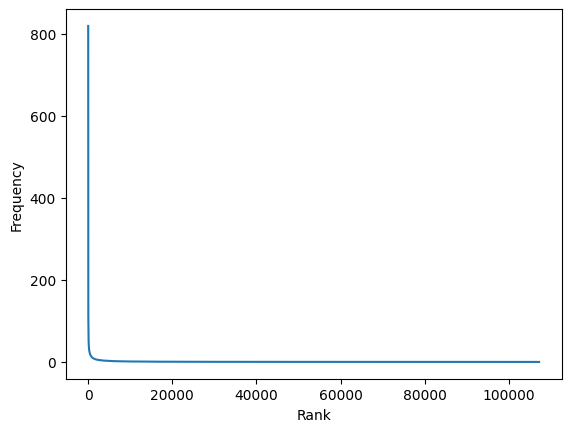

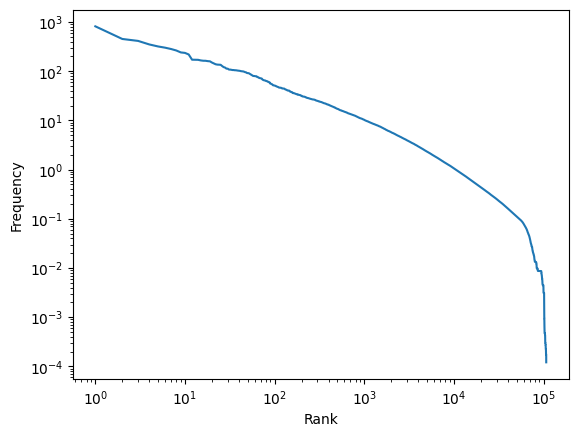

In [27]:
show_distribution(tfidf, train)

### Tutorial with bigram and trigram

In [28]:
tfidf_bigram = TfidfVectorizer(ngram_range=(2,2))
tfidf_trigram = TfidfVectorizer(ngram_range=(3,3))
tfidf_combined = TfidfVectorizer(ngram_range=(1,3))
tfidf_bigram.fit(train.data)
tfidf_trigram.fit(train.data)
tfidf_combined.fit(train.data)
tfidf_vectorizers = [tfidf, tfidf_bigram, tfidf_trigram, tfidf_combined]

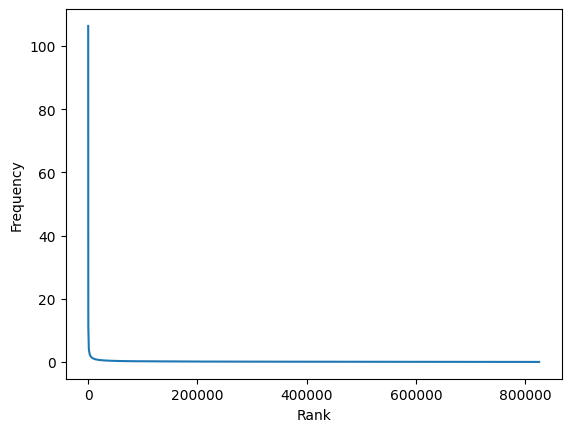

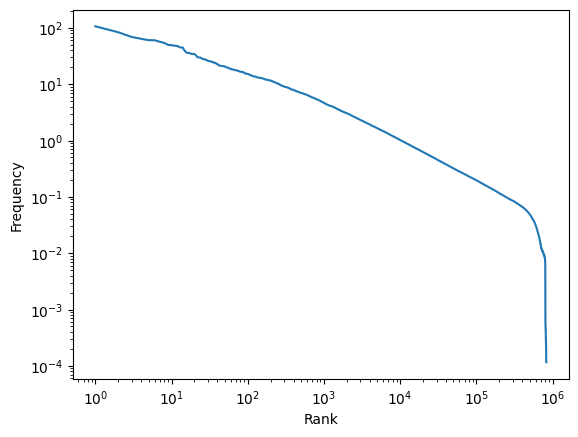

In [29]:
show_distribution(tfidf_bigram, train)

In [30]:
print('Vocabulary Size:', len(tfidf_bigram.vocabulary_))
sentence2vec('We are going to microsoft', tfidf_bigram)
print('Vocabulary Size:', len(tfidf_combined.vocabulary_))
sentence2vec('We are going to microsoft', tfidf_combined)

Vocabulary Size: 825425
" We are going to microsoft " -> 
  (0, 783807)	0.37403683743500654
  (0, 736413)	0.7336470123086184
  (0, 328698)	0.32571753506505674
  (0, 109903)	0.46450682763916384
783807 we are
736413 to microsoft
328698 going to
109903 are going

Vocabulary Size: 2447162
" We are going to microsoft " -> 
  (0, 2310052)	0.46430036807785535
  (0, 2309963)	0.2594895230780238
  (0, 2309753)	0.15107675883552044
  (0, 2166280)	0.5089704924175021
  (0, 2147049)	0.07123536394490301
  (0, 1336821)	0.33608081915392957
  (0, 919995)	0.225967817533126
  (0, 919583)	0.20152197161710347
  (0, 304443)	0.33233605156914814
  (0, 304432)	0.3222534336381154
  (0, 300895)	0.10594020037149467
2310052 we are going
2309963 we are
2309753 we
2166280 to microsoft
2147049 to
1336821 microsoft
919995 going to
919583 going
304443 are going to
304432 are going
300895 are



# Excercise 1
1. Find two documents that are very close in the Bag-of-word space but very far apart in the TFIDF space. 
2. Find two documents that are very close in the TFIDF space but very far apart in the Bag-of-word space. 

In [31]:
tfidf_vectors = tfidf.transform(train.data)

In [32]:
bow = CountVectorizer()
bow.fit(train.data)
bow_vectors = bow.transform(train.data)

In [33]:
cos_tfidf = cosine_similarity(tfidf_vectors)
cos_bow = cosine_similarity(bow_vectors)

In [34]:
cos_tfidf

array([[1.        , 0.04470404, 0.11153385, ..., 0.02597932, 0.04780809,
        0.08958609],
       [0.04470404, 1.        , 0.06288753, ..., 0.01340188, 0.03291365,
        0.05969698],
       [0.11153385, 0.06288753, 1.        , ..., 0.04887857, 0.06691767,
        0.15398204],
       ...,
       [0.02597932, 0.01340188, 0.04887857, ..., 1.        , 0.01615664,
        0.02895161],
       [0.04780809, 0.03291365, 0.06691767, ..., 0.01615664, 1.        ,
        0.07928381],
       [0.08958609, 0.05969698, 0.15398204, ..., 0.02895161, 0.07928381,
        1.        ]])

In [35]:
pd.DataFrame(cos_bow)

,0,1,2,3,4,5,6,7,8,9,...,7909,7910,7911,7912,7913,7914,7915,7916,7917,7918
0,1.000000,0.312760,0.515140,0.321309,0.373357,0.422188,0.274676,0.305019,0.286885,0.406475,...,0.351560,0.408474,0.460319,0.460367,0.172590,0.456133,0.148333,0.176545,0.323110,0.440039
1,0.312760,1.000000,0.367477,0.210414,0.248730,0.330909,0.226776,0.195384,0.271607,0.307287,...,0.255369,0.322818,0.362908,0.309928,0.169692,0.318914,0.173097,0.131818,0.268403,0.390542
2,0.515140,0.367477,1.000000,0.357064,0.520928,0.543917,0.236981,0.363050,0.350056,0.590660,...,0.419274,0.576288,0.701592,0.597899,0.174498,0.648514,0.194558,0.162569,0.417677,0.611727
3,0.321309,0.210414,0.357064,1.000000,0.350795,0.301970,0.110967,0.268891,0.167640,0.334441,...,0.259218,0.225277,0.335735,0.332869,0.126649,0.301364,0.109323,0.149160,0.327076,0.327408
4,0.373357,0.248730,0.520928,0.350795,1.000000,0.409726,0.133669,0.357012,0.244118,0.433813,...,0.350539,0.369756,0.495199,0.458251,0.141732,0.426188,0.105351,0.107062,0.442556,0.461302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7914,0.456133,0.318914,0.648514,0.301364,0.426188,0.566536,0.244061,0.262302,0.324361,0.516140,...,0.382332,0.616562,0.688528,0.597337,0.164519,1.000000,0.143771,0.128753,0.386248,0.568155
7915,0.148333,0.173097,0.194558,0.109323,0.105351,0.209462,0.179124,0.133751,0.160360,0.159959,...,0.212190,0.164331,0.131382,0.161197,0.112551,0.143771,1.000000,0.092990,0.112059,0.224941
7916,0.176545,0.131818,0.162569,0.149160,0.107062,0.176129,0.175292,0.135052,0.126750,0.141915,...,0.218941,0.145054,0.120029,0.187795,0.079430,0.128753,0.092990,1.000000,0.129777,0.195984
7917,0.323110,0.268403,0.417677,0.327076,0.442556,0.445177,0.161867,0.278920,0.229115,0.370020,...,0.260011,0.378022,0.395553,0.384321,0.162354,0.386248,0.112059,0.129777,1.000000,0.363200


In [36]:
diff = cos_bow - cos_tfidf 
np.where(diff==np.max(diff))

(array([ 524, 2397]), array([2397,  524]))

In [37]:
diff = cos_tfidf - cos_bow
np.where(diff==np.max(diff))

(array([ 726, 5339]), array([5339,  726]))

## Classification with MNB

- function for training and testing given vectorizer, classifier, return eval

In [38]:
def classification(vectorizer, model, fit_vect=False):
  if fit_vect:
    vectorizer.fit(train.data)
  train.vecs = vectorizer.transform(train.data)
  test.vecs = vectorizer.transform(test.data)
  model.fit(train.vecs, train.labels)
  train_preds = model.predict(train.vecs)
  train_f1 = f1_score(train.labels, train_preds, average='micro')
  test_preds = model.predict(test.vecs)
  test_f1 = f1_score(test.labels, test_preds, average='micro')
  return train_f1, test_f1  

### MNB with default parameters

In [39]:
model = MultinomialNB()
classification(tfidf_trigram, model)

(0.9963379214547291, 0.8150220913107512)

In [40]:
bow_trigram = CountVectorizer(ngram_range=(3,3))
bow_trigram.fit(train.data)
classification(bow_trigram, model)

(0.9984846571536811, 0.844182621502209)

In [41]:
model = MultinomialNB()
classification(tfidf_combined, model)

(0.9773961358757419, 0.8459499263622975)

In [42]:
model = MultinomialNB()
classification(tfidf, model)

(0.9307993433514332, 0.8273932253313696)

### Let's tune MNB (alpha)
Naive Bayes classifier for multinomial models ([Details](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


0.0 => (0.9996211642884203, 0.8871870397643593)
0.1 => (0.9994948857178937, 0.8827687776141384)
0.2 => (0.9992423285768405, 0.8804123711340206)
0.30000000000000004 => (0.9988634928652608, 0.8739322533136966)
0.4 => (0.9983583785831545, 0.8680412371134021)
0.5 => (0.9982321000126277, 0.8612665684830634)
0.6000000000000001 => (0.9981058214421012, 0.8574374079528719)
0.7000000000000001 => (0.9979795428715746, 0.8536082474226804)
0.8 => (0.9973481500189418, 0.8512518409425626)
0.9 => (0.9972218714484152, 0.8480117820324006)


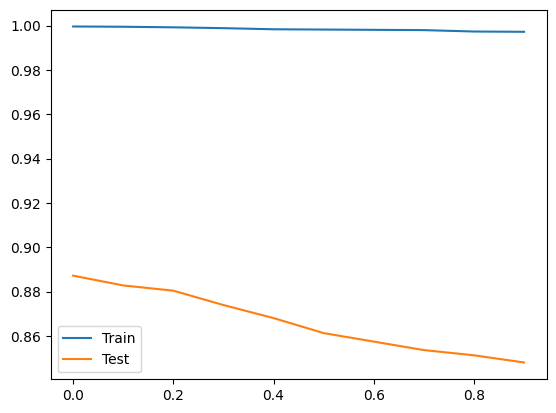

In [43]:
arange = np.arange(0, 1, 0.1)
results = []
for a in arange:
  model = MultinomialNB(alpha=a)
  res = classification(bigram, model)
  results.append(res)
  print(a, '=>', res)
  
plt.plot(arange, results)
plt.legend(["Train", "Test"])
plt.show()

### Let's compare different n-grams with a fixed alpha for MNB

unigram => (0.9857305215304962, 0.8904270986745213)
bigram => (0.9989897714357874, 0.8686303387334315)
trigram => (0.9997474428589468, 0.8483063328424153)
combined => (0.9987372142947342, 0.8871870397643593)


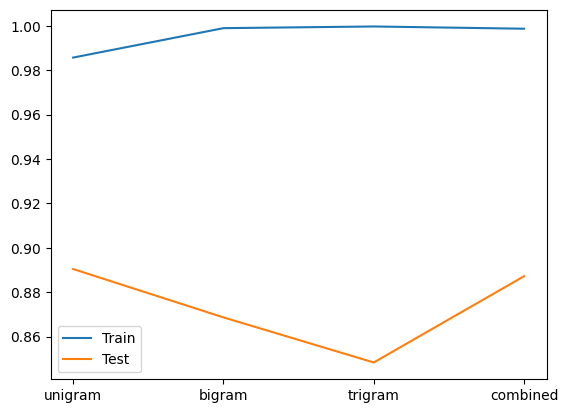

In [44]:
vectorizer_names = ['unigram', 'bigram', 'trigram', 'combined']
xs = list(range(len(vectorizer_names)))
results = []
for i in range(len(tfidf_vectorizers)):
  model = MultinomialNB(alpha=0.1)
  res = classification(tfidf_vectorizers[i], model)
  results.append(res)
  print(vectorizer_names[i], '=>', res)
  
plt.plot(xs, results)
plt.xticks(xs, vectorizer_names)
plt.legend(["Train", "Test"])
plt.show()

## Excercise2: Let's tune TfidfVectorizer with a fixed alpha for MNB
Compare TfidfVectorizers with different parameters ([Details](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer))  
e.g.,
- stop_words =‘english’(None by default)
- min_df = 5 (1 by default)
- sublinear_tf = True (False by default)
- use_idf = False (True by default)
- binary = True (False by default)

default => (0.9992423285768405, 0.9007363770250368)
Stopwords English => (0.9992423285768405, 0.8995581737849779)
Sublinear T & Stopwords => (0.999116050006314, 0.9036818851251841)
Min df 100 & Max df 0.7 => (0.9015027149892664, 0.7808541973490427)
Min df 5 & Max df 0.7 => (0.9962116428842025, 0.8854197349042711)
Min df 100 & Max df 0.7 & Sublinear T => (0.9049122363934841, 0.7770250368188512)
Stopwords Max 0.5 & Sublinear => (0.999116050006314, 0.9036818851251841)


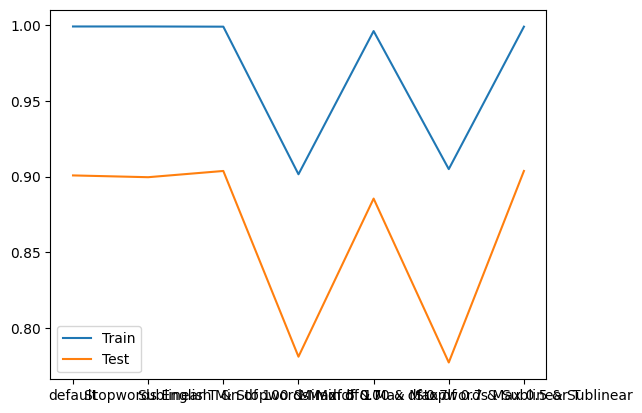

In [45]:
tfidf_vectorizers = [TfidfVectorizer(), TfidfVectorizer(stop_words ="english"), TfidfVectorizer(sublinear_tf=True, stop_words ="english"),  TfidfVectorizer(min_df=100, max_df=0.7),
                    TfidfVectorizer(min_df=5, max_df=0.7), TfidfVectorizer(min_df=100, max_df=0.7, sublinear_tf=True), TfidfVectorizer(stop_words ="english", max_df=0.5, sublinear_tf = True)] # add parameters to each vectorizer
names = ['default', 'Stopwords English', 'Sublinear T & Stopwords', 'Min df 100 & Max df 0.7', 'Min df 5 & Max df 0.7', 'Min df 100 & Max df 0.7 & Sublinear T', 'Stopwords Max 0.5 & Sublinear'] # give short names to say what you changed
xs = list(range(len(tfidf_vectorizers)))
results = list()
for i in range(len(tfidf_vectorizers)):
  tfidf_vectorizers[i].fit(train.data)
  model = MultinomialNB(alpha=0.0001) # set a very small value
  res = classification(tfidf_vectorizers[i], model) # we need to set fit_vect=True, but why?
  results.append(res)
  print(names[i], '=>', res)
  
plt.plot(xs, results)
plt.xticks(xs, names)
plt.legend(["Train", "Test"])
plt.show()

### What parameter did you change to get the best test performance?

### [Optional] Let's tune parameters of TfidfVectorizer and MNB simultaneously
This parameter tuning is called ***grid search***

In [ ]:
min_dfs = np.arange(1, 50, 5)
alphas = np.arange(0.001, 1.0, 0.1)
xx, yy = np.meshgrid(alphas, min_dfs)
f1_score_mat = np.zeros((len(min_dfs), len(alphas)))
for i in range(len(min_dfs)):
  tfidf_vectorizer = TfidfVectorizer(min_df=min_dfs[i])
  for j in range(len(alphas)):
    model = MultinomialNB(alpha=alphas[j])
    res = classification(tfidf_vectorizer, model, fit_vect=True)
    f1_score_mat[i][j] = res[1]
    
plt.contourf(alphas, min_dfs, f1_score_mat, cmap=plt.cm.viridis, levels=np.arange(0.0,1.05,0.05))
plt.ylabel('min_df')
plt.xlabel('alpha')
plt.colorbar()
plt.show()